## Base de Dados
A base de dados conta com registros de partidas profissionais de Dota 2, contendo o número de identificador de cada personagem selecionado, a taxa de vitória desse personagem selecionado e a medalha da pessoa jogadora.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# variável usada para remover warnings do jupyter notebook
import warnings
warnings.filterwarnings('ignore')

# leitura e transformação do arquivo em dataframe
dados = pd.read_csv('dadosmedalhataxavitoria.csv')
dados = dados.drop_duplicates()

dados = dados.drop(columns=['Unnamed: 0', 'id'])
dados['winner'] = dados['winner'].apply(lambda item: 1 if item == 'radiant' else 0)
dados

,winner,pick1,taxavitoria1,rank1,pick2,taxavitoria2,rank2,pick3,taxavitoria3,rank3,...,rank7,pick8,taxavitoria8,rank8,pick9,taxavitoria9,rank9,pick10,taxavitoria10,rank10
0,0,5,51.39,80,95,47.54,75,128,46.33,75,...,73,71,51.55,80,87,49.85,80,3,51.08,80
1,1,90,49.96,80,80,49.43,80,40,51.92,80,...,80,92,49.87,80,101,51.95,80,62,53.93,80
2,0,4,51.48,75,11,47.00,75,105,50.84,75,...,75,30,46.77,75,101,51.95,75,46,48.13,75
3,1,101,51.95,80,104,54.35,80,13,48.30,80,...,80,19,45.24,80,65,51.34,80,111,53.48,80
4,0,71,51.55,80,59,50.25,80,120,50.21,80,...,80,62,53.93,80,97,48.86,80,10,45.52,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1474,1,126,48.22,70,87,49.85,70,96,47.70,70,...,70,63,48.55,70,138,48.06,70,89,54.47,70
1475,1,73,51.31,70,33,49.16,70,85,53.33,70,...,70,129,42.92,70,8,46.56,70,106,49.86,70
1476,1,104,54.35,80,126,48.22,80,75,52.01,80,...,80,136,49.49,80,91,49.88,80,73,51.31,80
1477,0,73,51.31,80,94,54.30,70,90,49.96,80,...,70,86,48.71,70,87,49.85,70,120,50.21,70


## Escolha do Melhor Algoritmo
Para a escolha do melhor algoritmo foram utilizados de diversos algoritmos explorados na literatura, de forma que foi calculado sua acurácia e sua precisão. O algoritmo com melhor precisão foi escolhido e a partir disso feito um ajuste dos parâmetros para determinar a melhor precisão possível para o problema.

Melhor Algoritmo Escolhido:
Precisão e Acurácia:
Precisão e Acurácia depois do Ajuste de Parâmetros:

### Funções Auxiliares
Para auxiliar nos cálculos necessários de verificação dos algoritmos foram desenvolvidas algumas funções que realizam o cálculo e impressão das métricas, separação do conjunto de teste, entre outras questões, como por exemplo salvar os dados no framework MLFlow, que facilitou a leitura a verificação dos melhores resultados.

In [2]:
import mlflow
import mlflow.sklearn
import os

# função auxiliar para criar um experimento no mlflow
def criarExperimento():
    # variáveis de conexão com o mlflow
    os.environ['MLFLOW_TRACKING_URI'] = "https://dagshub.com/stardotwav/Dota2Predictor.mlflow"
    os.environ['MLFLOW_TRACKING_USERNAME'] = "stardotwav"
    os.environ['MLFLOW_TRACKING_PASSWORD'] = "7dcb76dec399290fb3a125d02a9a7b39e2c03d90"
    
    mlflow.set_tracking_uri(os.environ['MLFLOW_TRACKING_URI'])
    mlflow.set_experiment(experiment_name='Personagens Selecionados, Taxa de Vitória de Personagens e Medalha das Pessoas Jogadoras')

    tags = {
            "Projeto": "Projeto de Engenharia de Aprendizado de Máquina",
            "team": "Estela",
            "dataset": "dota2teamsprofessionals"
           }

In [3]:
# função auxiliar que salva os dados no MLFlow
def modelosMLFlow(acuracia, modelo, nomeModelo):
    with  mlflow.start_run(run_name=nomeModelo):
        # registro das métricas
        mlflow.log_metric("Acurácia", acuracia)
        
        # registro do modelo
        mlflow.sklearn.log_model(modelo, "Modelo")
        mlflow.end_run()

In [3]:
# import utilizado para realizar a separação do treino e teste
from sklearn.model_selection import train_test_split

# função auxiliar que realiza a separação do dataset em treino e teste
def separacaoModelo(dataset, target):
    X = dataset.drop(target, axis=1)
    Y = dataset[target]
    xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    return xTrain, xTest, yTrain, yTest

In [4]:
# import de algoritmos utilizados
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# função auxiliar que gerar qualquer modelo de acordo com seu nome
def gerarModelo(xTrain, xTest, yTrain, yTest, modelo):
    md = modelo
    md.fit(xTrain, yTrain)
    pred = md.predict(xTest)
    
    return md, pred

In [6]:
# import do cross_validation
from sklearn.model_selection import cross_val_score

# grafico que gera comparação entre diversos algoritmos
def graficoComparacao(algoritmos, nomes, x, y):
    scores = {}
    cont = 0
    for i in algoritmos:
        scores[nomes[cont]] = cross_val_score(i, x, y, cv=30)
        cont += 1

    scores = pd.DataFrame.from_dict(scores)
    plt.figure(figsize = (15,10))
    sns.set(font_scale=1.7)
    sns.boxplot(data=scores, palette='rocket')

In [5]:
# gerando base de dados
xTrain, xTest, yTrain, yTest = separacaoModelo(dados, 'winner')

In [8]:
# criando experimento
criarExperimento()

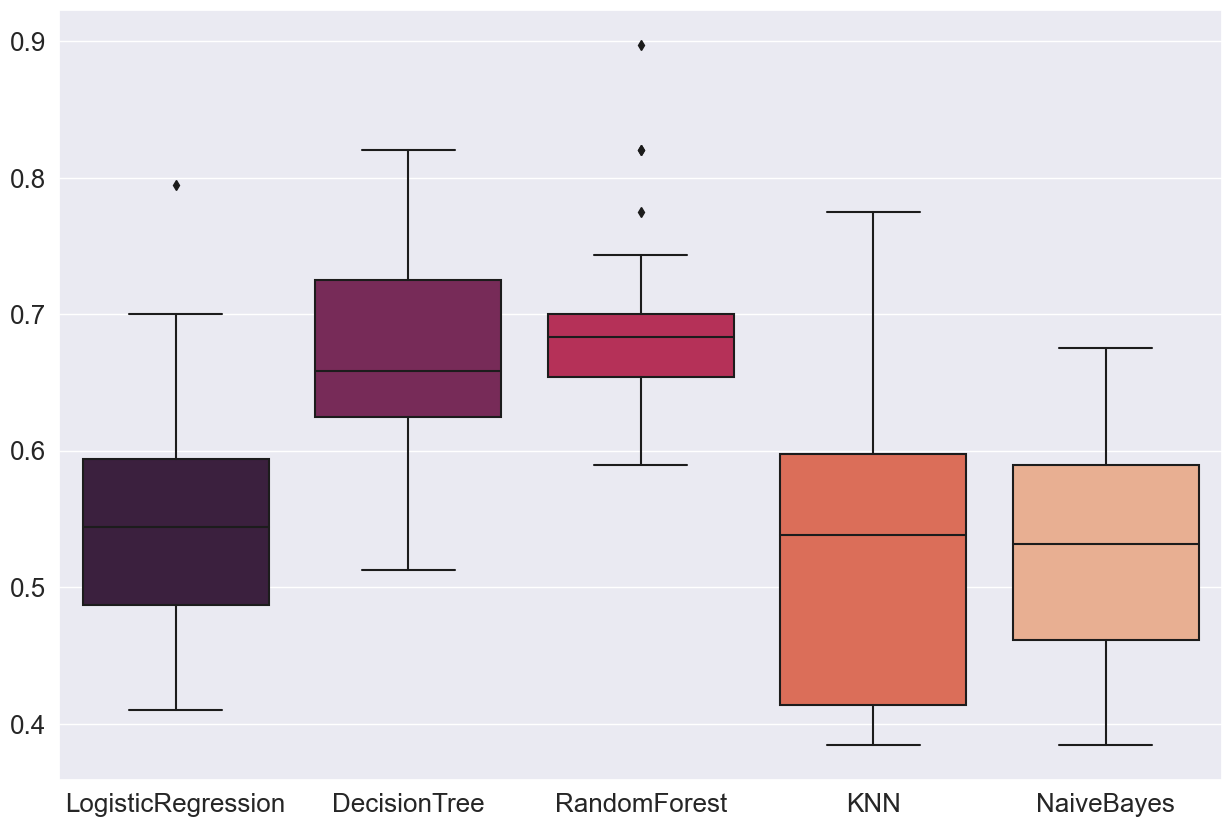

In [9]:
algoritmos = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), KNeighborsClassifier(), GaussianNB()]
nomes = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'KNN', 'NaiveBayes']

# gerando graficos de comparacao, usando do treino e do teste
graficoComparacao(algoritmos, nomes, xTrain, yTrain)

### Decision Tree

In [10]:
# imports necessário
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint

# parâmetros que serão aleatoriezados
parameters = {'criterion': ['entropy', 'gini'], 'max_depth': [None, 50, 100], 'min_samples_split': [2, 4, 6],
              'max_features': ['auto', 'sqrt', 'log2']}

# classificador usado
dt = DecisionTreeClassifier(random_state=42)

# geração do gridsearch
clf = GridSearchCV(estimator=dt, param_grid=parameters, cv=30)
clf.fit(xTrain, yTrain)

GridSearchCV(cv=30, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [None, 50, 100],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 4, 6]})

In [11]:
# melhores parâmetros
clf.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_split': 6}

In [12]:
# melhor score
clf.best_score_

0.6345940170940172

In [13]:
modelosMLFlow(clf.best_score_, dt, "Decision Tree")

In [31]:
from sklearn.metrics import accuracy_score

dt = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=None, min_samples_split=6)
dt.fit(xTrain, yTrain)
pred = dt.predict(xTest)
acuracia = accuracy_score(yTest, pred)
print(f'Acurácia: {acuracia}')

Acurácia: 0.6317567567567568


### Logistic Regression

In [14]:
# parâmetros que serão aleatoriezados
parameters = {'penalty': ['l1', 'l2', 'elasticnet'], 'tol': [0.0001, 0.001, 0.01, 0.0004, 0.004]}

# classificador usado
lr = LogisticRegression()

# geração do gridsearch
clf = GridSearchCV(estimator=lr, param_grid=parameters, cv=30)
clf.fit(xTrain, yTrain)

GridSearchCV(cv=30, estimator=LogisticRegression(),
             param_grid={'penalty': ['l1', 'l2', 'elasticnet'],
                         'tol': [0.0001, 0.001, 0.01, 0.0004, 0.004]})

In [15]:
# melhores parâmetros
clf.best_params_

{'penalty': 'l2', 'tol': 0.0001}

In [16]:
# melhor score
clf.best_score_

0.5487179487179487

In [17]:
modelosMLFlow(clf.best_score_, lr, "Logistic Regression")

In [32]:
dt = LogisticRegression(penalty='l2', tol=0.0001)
dt.fit(xTrain, yTrain)
pred = dt.predict(xTest)
acuracia = accuracy_score(yTest, pred)
print(f'Acurácia: {acuracia}')

Acurácia: 0.527027027027027


### KNN

In [18]:
# parâmetros que serão aleatoriezados
parameters = {'n_neighbors': [5, 10, 15, 20], 'algorithm': ['auto', 'brute', 'kd_tree', 'ball_tree'], 
              'metric': ['cosine', 'euclidean', 'manhattan', 'minkowski']}

# classificador usado
knn = KNeighborsClassifier()

# geração do gridsearch
clf = GridSearchCV(estimator=knn, param_grid=parameters, cv=30)
clf.fit(xTrain, yTrain)

GridSearchCV(cv=30, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'brute', 'kd_tree', 'ball_tree'],
                         'metric': ['cosine', 'euclidean', 'manhattan',
                                    'minkowski'],
                         'n_neighbors': [5, 10, 15, 20]})

In [19]:
# melhores parâmetros
clf.best_params_

{'algorithm': 'auto', 'metric': 'cosine', 'n_neighbors': 10}

In [20]:
# melhor score
clf.best_score_

0.5558547008547007

In [21]:
modelosMLFlow(clf.best_score_, knn, "KNN")

In [33]:
dt = KNeighborsClassifier(algorithm='auto', metric='cosine', n_neighbors=10)
dt.fit(xTrain, yTrain)
pred = dt.predict(xTest)
acuracia = accuracy_score(yTest, pred)
print(f'Acurácia: {acuracia}')

Acurácia: 0.5067567567567568


### Naive Bayes

In [22]:
# parâmetros que serão aleatoriezados
parameters = {'priors': [None, [0.1,]*10],
            'var_smoothing': [1e-9, 1e-6, 1e-12]}

# classificador usado
nb = GaussianNB()

# geração do gridsearch
clf = GridSearchCV(estimator=nb, param_grid=parameters, cv=30)
clf.fit(xTrain, yTrain)

GridSearchCV(cv=30, estimator=GaussianNB(),
             param_grid={'priors': [None,
                                    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
                                     0.1, 0.1]],
                         'var_smoothing': [1e-09, 1e-06, 1e-12]})

In [23]:
# melhores parâmetros
clf.best_params_

{'priors': None, 'var_smoothing': 1e-09}

In [24]:
# melhor score
clf.best_score_

0.5283119658119658

In [25]:
modelosMLFlow(clf.best_score_, nb, "Naive Bayes")

In [34]:
dt = GaussianNB(priors=None, var_smoothing=1e-09)
dt.fit(xTrain, yTrain)
pred = dt.predict(xTest)
acuracia = accuracy_score(yTest, pred)
print(f'Acurácia: {acuracia}')

Acurácia: 0.5067567567567568


### Random Forest

In [26]:
# parâmetros que serão aleatoriezados
parameters = {'n_estimators': [50, 100, 200], 'criterion': ['entropy', 'gini'],
              'max_depth': [None, 50, 100], 'min_samples_split': [2, 4, 6],
              'max_features': ['auto', 'sqrt', 'log2'], 'bootstrap': [True, False]}

# classificador usado
rf = RandomForestClassifier(random_state=42)

# geração do gridsearch
clf = GridSearchCV(estimator=rf, param_grid=parameters, cv=10)
clf.fit(xTrain, yTrain)
#clf.cv_results_

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['entropy', 'gini'],
                         'max_depth': [None, 50, 100],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [50, 100, 200]})

In [27]:
# melhores parâmetros
clf.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_split': 6,
 'n_estimators': 100}

In [28]:
# melhor score
clf.best_score_

0.7176256943455347

In [29]:
modelosMLFlow(clf.best_score_, rf, "Random Forest")

In [6]:
from sklearn.metrics import accuracy_score

dt = RandomForestClassifier(random_state=42, bootstrap=False, criterion='entropy', max_depth=None, min_samples_split=6, n_estimators=100)
dt.fit(xTrain, yTrain)
pred = dt.predict(xTest)
acuracia = accuracy_score(yTest, pred)
print(f'Acurácia: {acuracia}')

Acurácia: 0.7162162162162162


<Axes: >

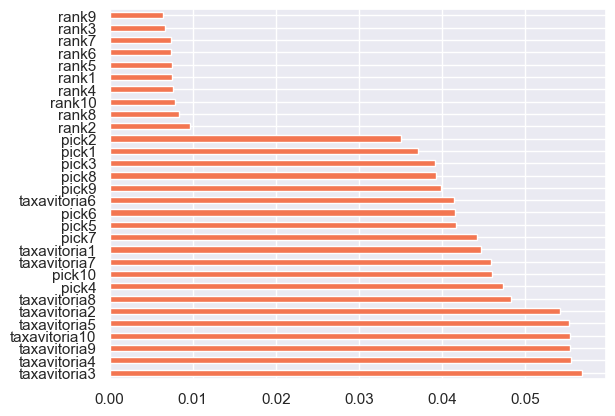

In [8]:
# Create a series containing feature importances from the model and feature names from the training data
sns.set(font_scale=1)
feature_importances = pd.Series(dt.feature_importances_, index=xTrain.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot(kind='barh', color='#f37651')